Loaded 1017 valid molecules.


[04:54:50] DEPRECATION WARNING: please use MorganGenerator
[04:54:50] DEPRECATION WARNING: please use MorganGenerator
[04:54:50] DEPRECATION WARNING: please use MorganGenerator
[04:54:50] DEPRECATION WARNING: please use MorganGenerator
[04:54:50] DEPRECATION WARNING: please use MorganGenerator
[04:54:50] DEPRECATION WARNING: please use MorganGenerator
[04:54:50] DEPRECATION WARNING: please use MorganGenerator
[04:54:50] DEPRECATION WARNING: please use MorganGenerator
[04:54:50] DEPRECATION WARNING: please use MorganGenerator
[04:54:50] DEPRECATION WARNING: please use MorganGenerator
[04:54:50] DEPRECATION WARNING: please use MorganGenerator
[04:54:50] DEPRECATION WARNING: please use MorganGenerator
[04:54:50] DEPRECATION WARNING: please use MorganGenerator
[04:54:50] DEPRECATION WARNING: please use MorganGenerator
[04:54:50] DEPRECATION WARNING: please use MorganGenerator
[04:54:50] DEPRECATION WARNING: please use MorganGenerator
[04:54:50] DEPRECATION WARNING: please use MorganGenerat

Morgan diversity set:


/usr/local/lib/python3.12/dist-packages/rdkit/Chem/Draw/IPythonConsole.py:365: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


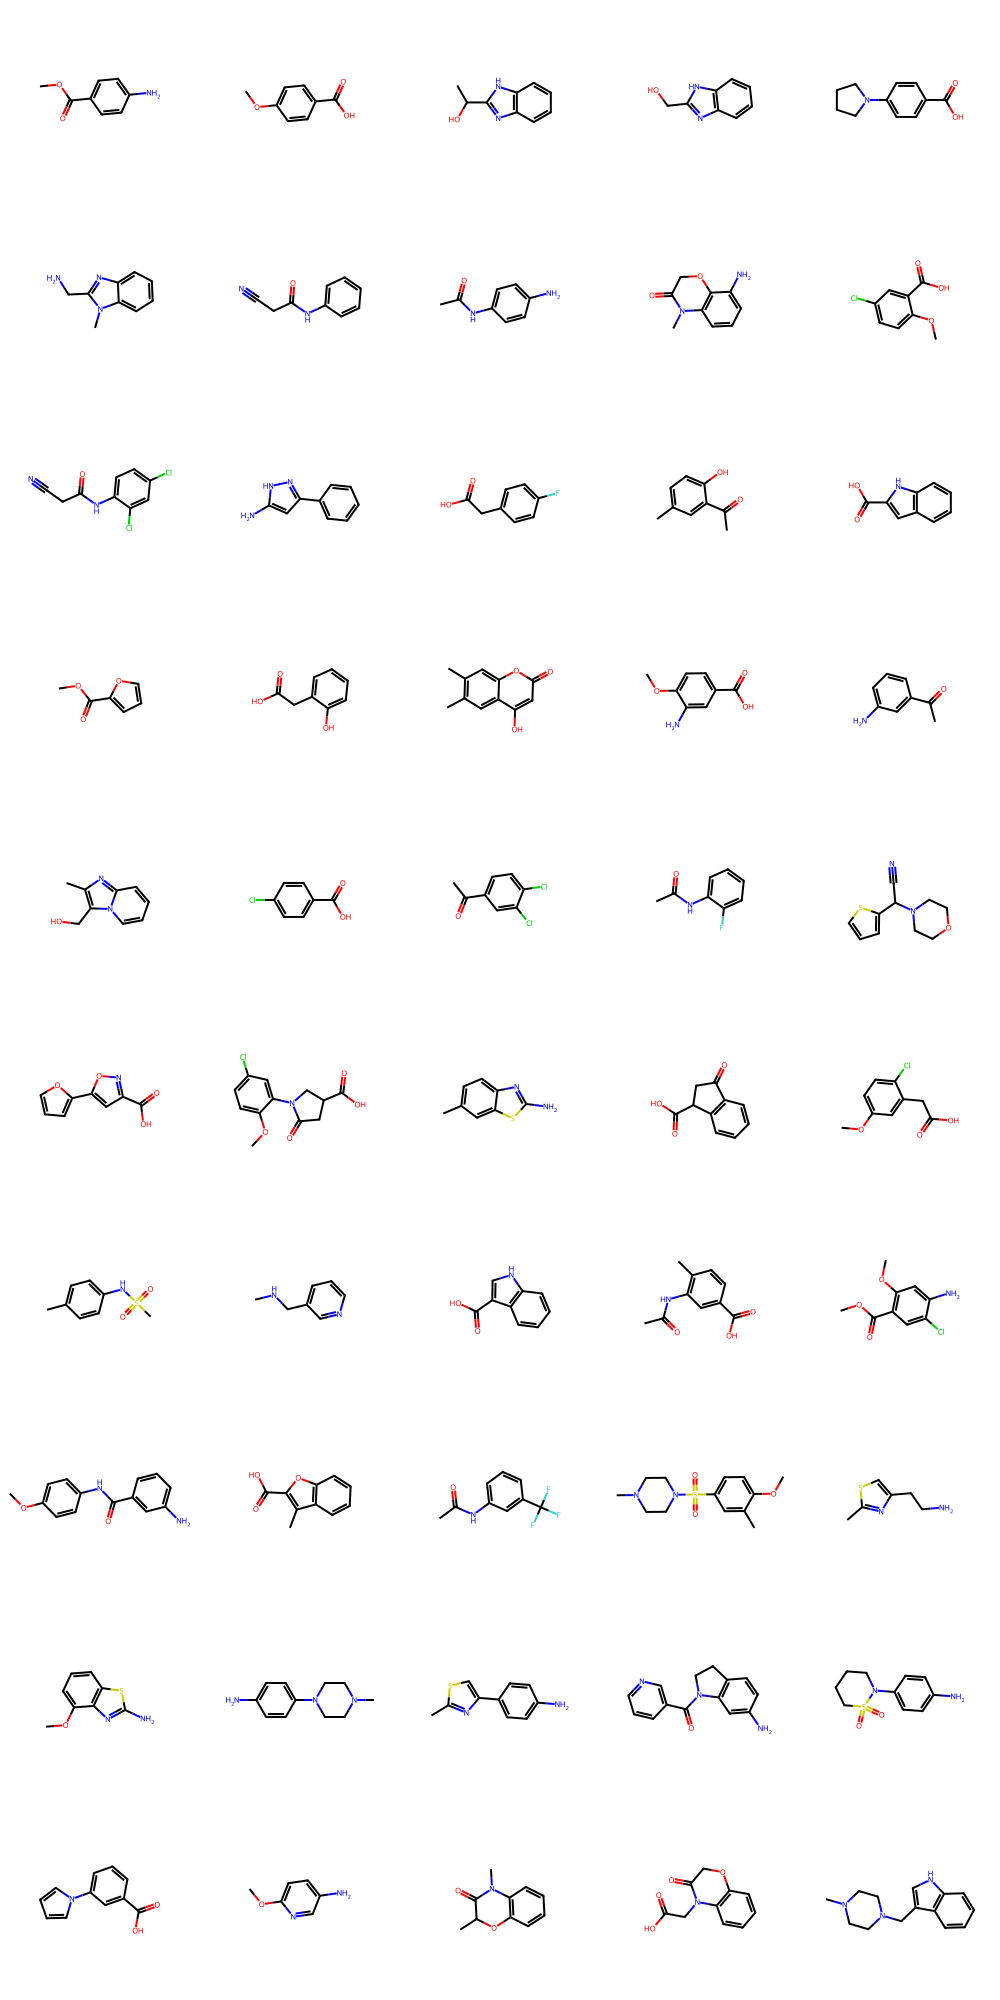

AtomPair diversity set:


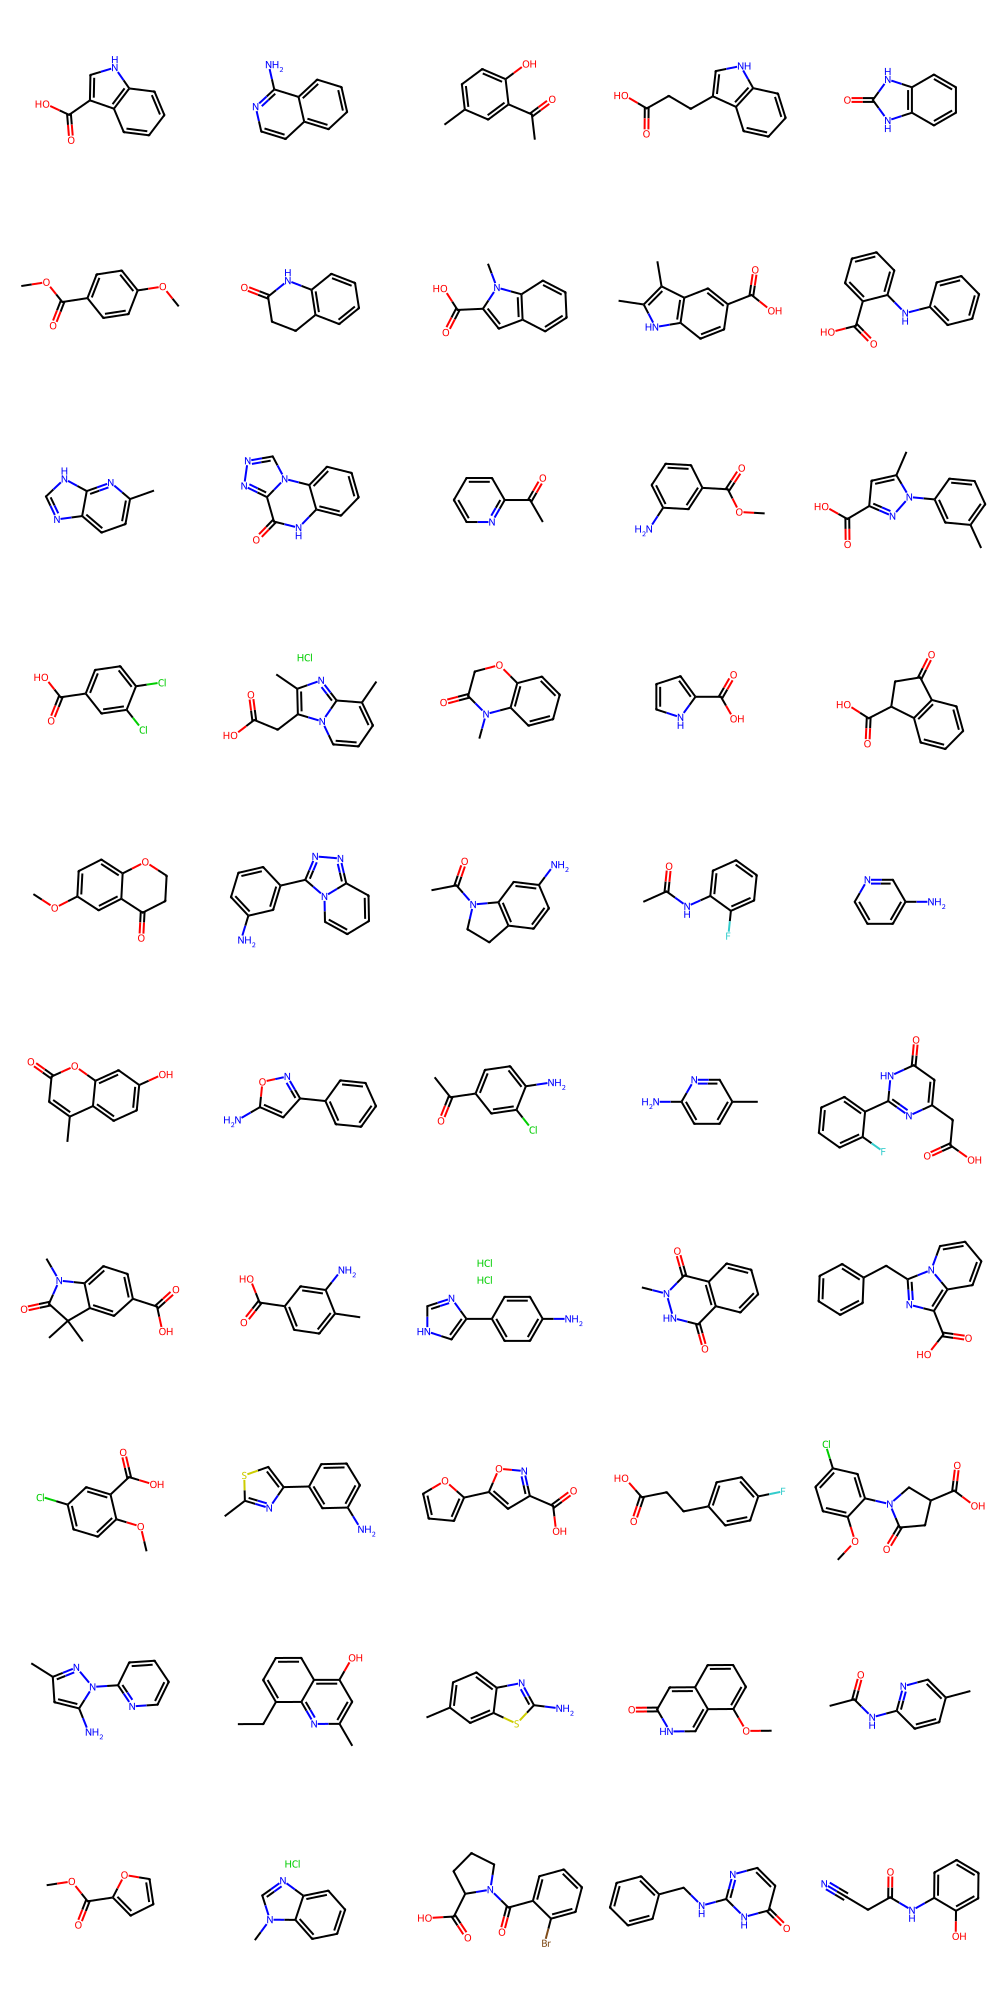

Topological Torsion diversity set:


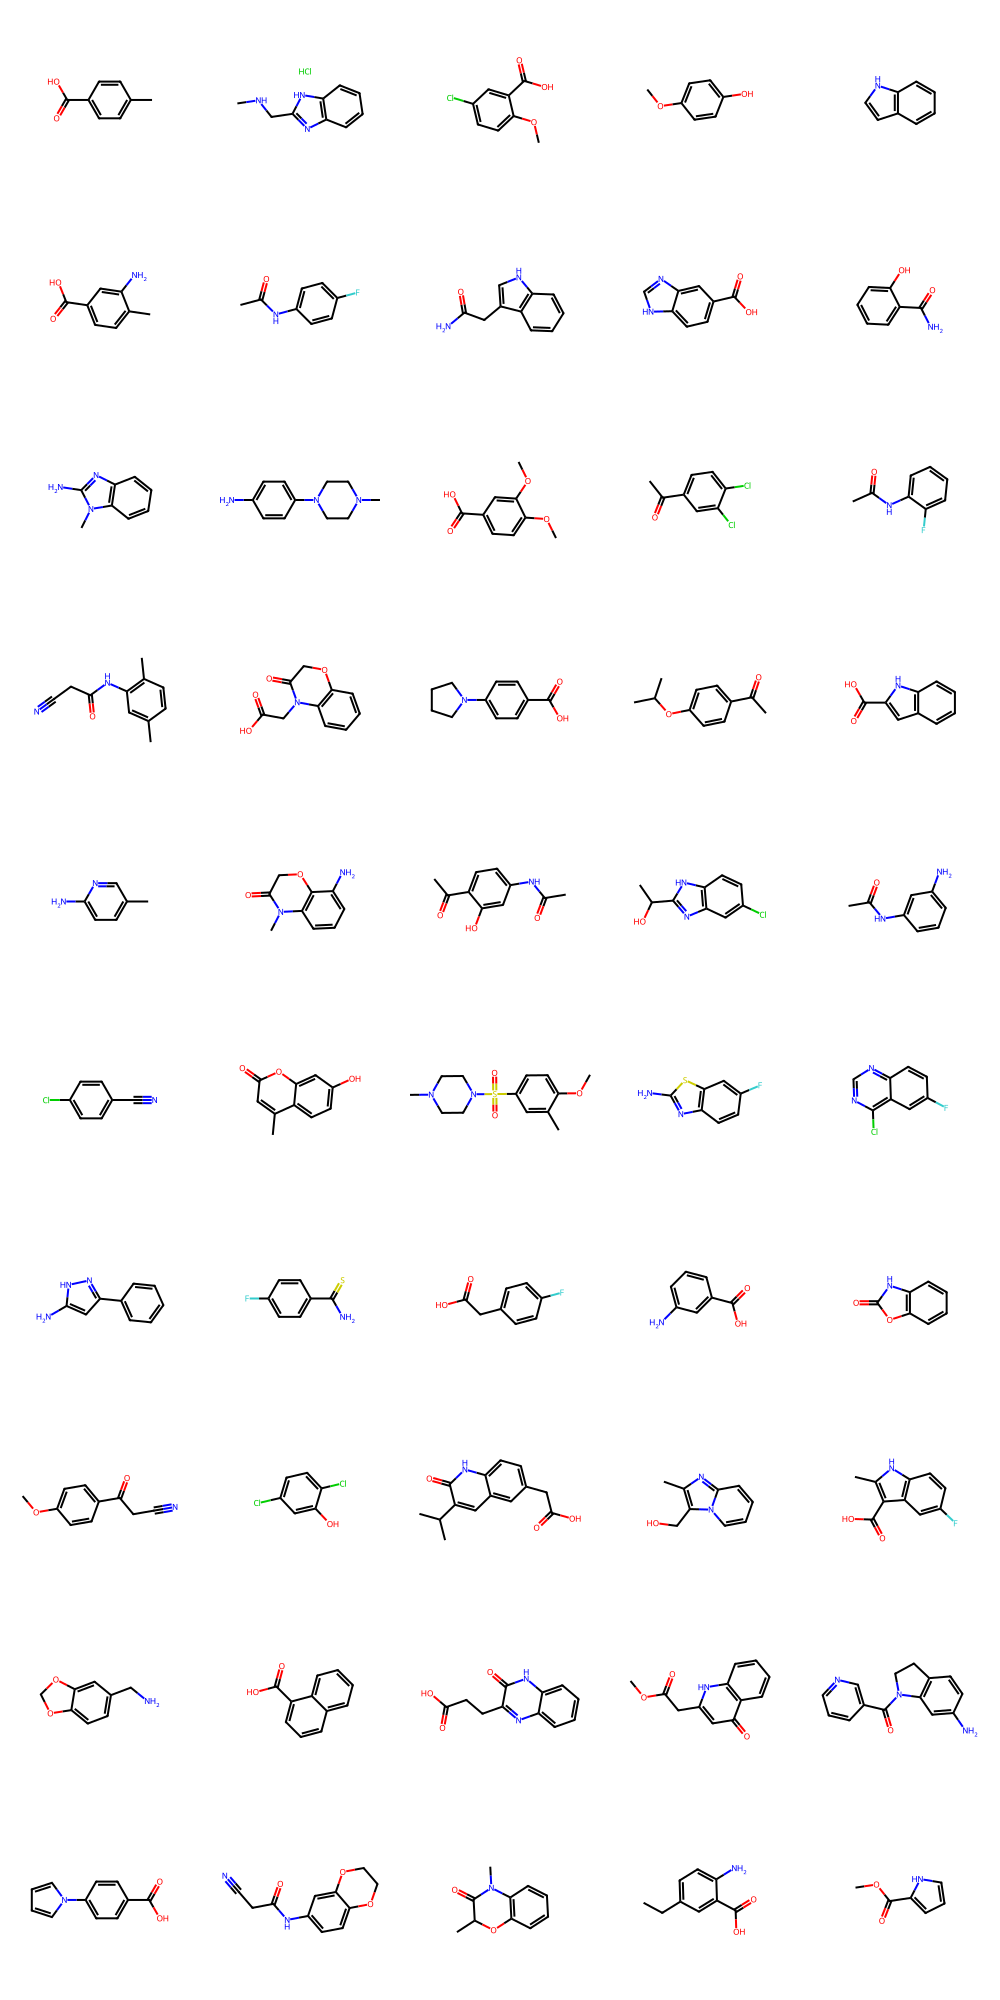

RDKit FP diversity set:


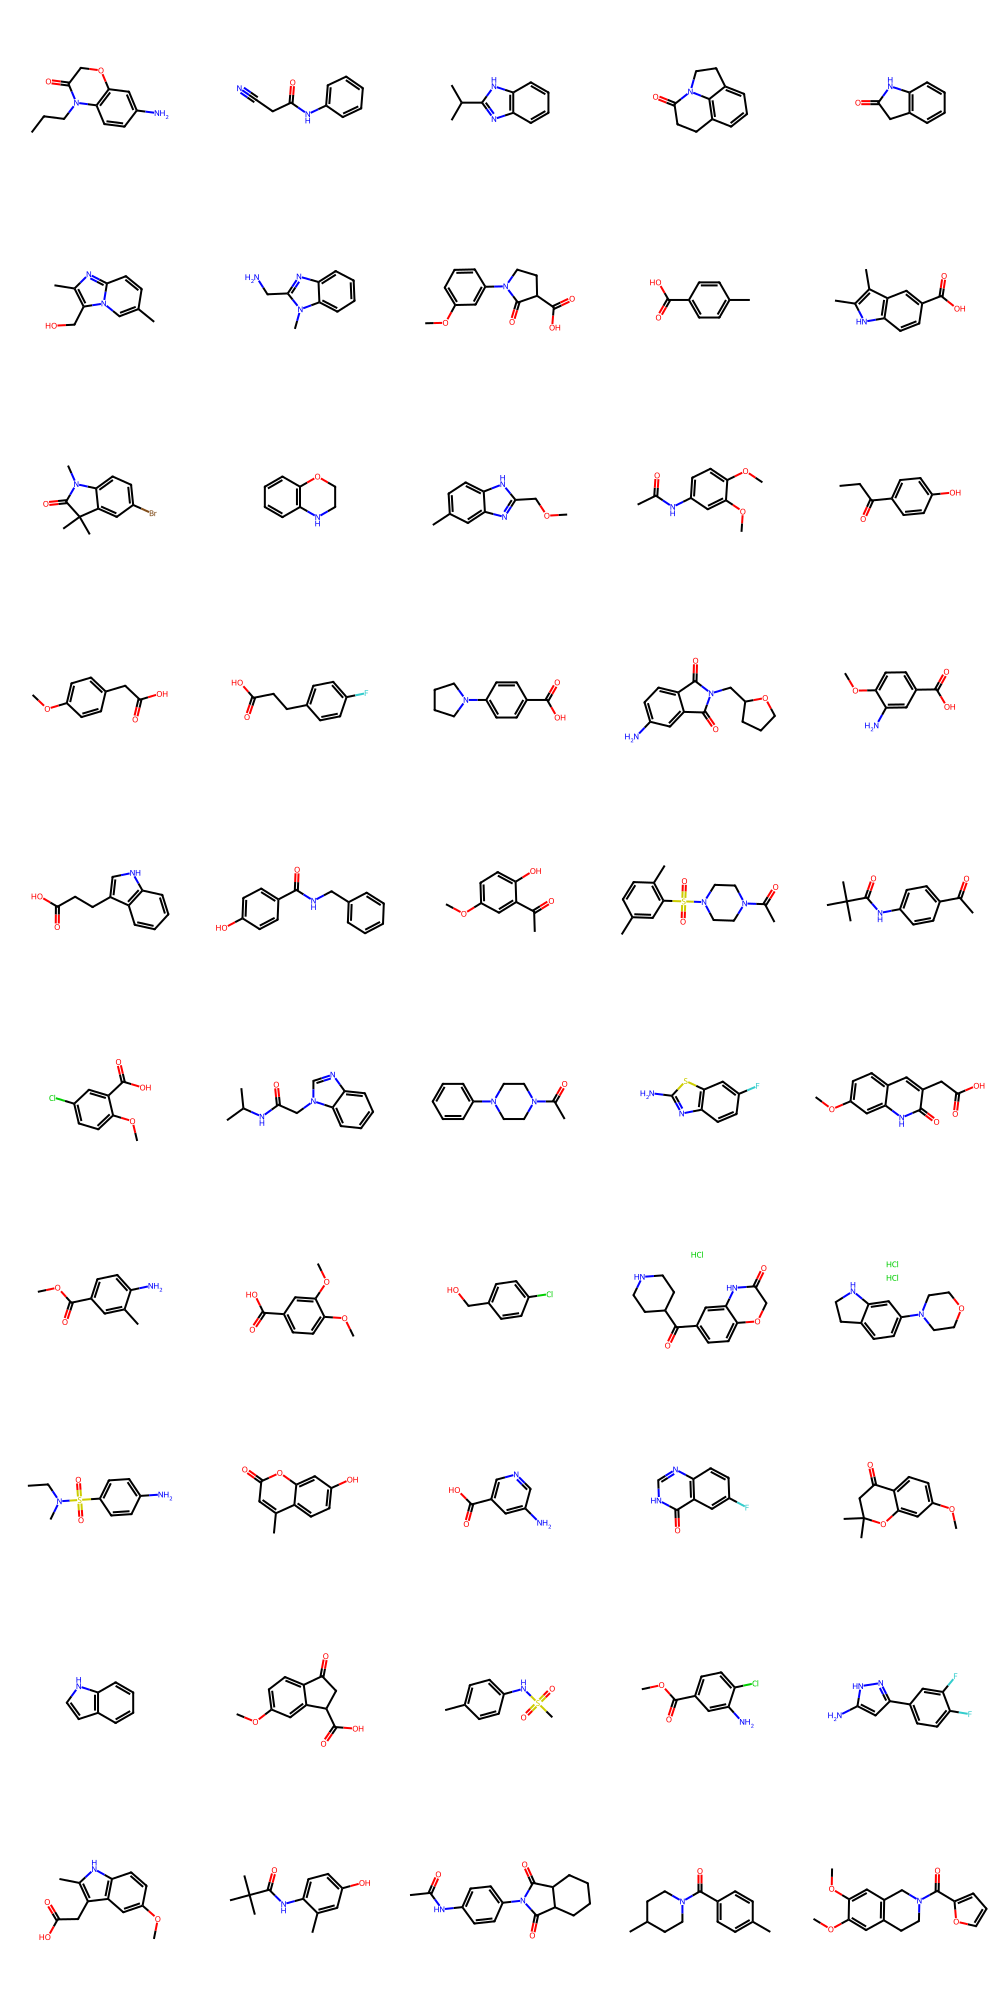

Saved 748 Morgan representatives to 50_diverse_morgan.csv.
Saved 527 AtomPair representatives to 50_diverse_atompair.csv.
Saved 621 Torsion representatives to 50_diverse_torsion.csv.
Saved 505 RDKit representatives to 50_diverse_rdkit.csv.


,RDKit_Name,RDKit_SMILES
0,873,CCCN1C(=O)COc2cc(N)ccc21
1,225,N#CCC(=O)Nc1ccccc1
2,139,CC(C)c1nc2ccccc2[nH]1
3,517,O=C1CCc2cccc3c2N1CC3
4,769,O=C1Cc2ccccc2N1
...,...,...
500,18,Cn1ncc(Cl)c(Cl)c1=O
501,14,CN1CCN(S(=O)(=O)c2cccs2)CC1
502,8,Cc1ccc(NC2CS(=O)(=O)CC2O)cc1C
503,4,Cc1ccccc1NC(N)=S


In [12]:
!pip install rdkit

# Diversity Selection of Molecules from SMILES in CSV
# ---------------------------------------------------
# Requirements: RDKit, pandas, numpy

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from IPython.display import display

# 1. Load SMILES from CSV
# csv file contains NAME and SMILES coloums
df = pd.read_csv("molecules.csv")   # assumes a column named "SMILES"
smiles_list = df["SMILES"].dropna().tolist()

# 2. Convert SMILES to RDKit molecules
mols = [Chem.MolFromSmiles(smi) for smi in smiles_list if Chem.MolFromSmiles(smi)]
print(f"Loaded {len(mols)} valid molecules.")

# 3. Generate fingerprints (legacy APIs)
from rdkit.Chem import AllChem, RDKFingerprint
from rdkit.Chem.AtomPairs import Pairs, Torsions

# Morgan (ECFP4)
fps_morgan = [AllChem.GetMorganFingerprintAsBitVect(m, radius=2, nBits=2048) for m in mols]

# AtomPair
fps_atompair = [Pairs.GetAtomPairFingerprintAsBitVect(m) for m in mols]

# Topological Torsion
fps_torsion = [Torsions.GetTopologicalTorsionFingerprintAsIntVect(m) for m in mols]

# RDKit path-based
fps_rdkit = [RDKFingerprint(m) for m in mols]

# 4. Helper: cluster molecules with Butina
def cluster_fps(fps, cutoff=0.7):
    nfps = len(fps)
    dists = []
    for i in range(1, nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps[:i])
        dists.extend([1.0 - x for x in sims])
    clusters = Butina.ClusterData(dists, nfps, cutoff, isDistData=True)
    return clusters

def representatives(clusters, mols):
    return [mols[cluster[0]] for cluster in clusters]

def cluster_summary(clusters, label):
    sizes = [len(c) for c in clusters]
    print(f"{label}: {len(clusters)} clusters | avg size {np.mean(sizes):.2f} | max size {np.max(sizes)}")

# 5. Cluster with each fingerprint type
clusters_morgan = cluster_fps(fps_morgan, cutoff=0.70)
clusters_atompair = cluster_fps(fps_atompair, cutoff=0.70)
clusters_torsion = cluster_fps(fps_torsion, cutoff=0.70)
clusters_rdkit = cluster_fps(fps_rdkit, cutoff=0.70)

# 6. Representatives
diverse_mols_morgan = representatives(clusters_morgan, mols)
diverse_mols_atompair = representatives(clusters_atompair, mols)
diverse_mols_torsion = representatives(clusters_torsion, mols)
diverse_mols_rdkit = representatives(clusters_rdkit, mols)

# 7. Visualize diversity sets
print("Morgan diversity set:")
display(Draw.MolsToGridImage(diverse_mols_morgan, molsPerRow=5, subImgSize=(200,200)))

print("AtomPair diversity set:")
display(Draw.MolsToGridImage(diverse_mols_atompair, molsPerRow=5, subImgSize=(200,200)))

print("Topological Torsion diversity set:")
display(Draw.MolsToGridImage(diverse_mols_torsion, molsPerRow=5, subImgSize=(200,200)))

print("RDKit FP diversity set:")
display(Draw.MolsToGridImage(diverse_mols_rdkit, molsPerRow=5, subImgSize=(200,200)))

# 8. Save representative SMILES + Names to CSV
# assumes a column named "NAME"
def save_reps(clusters, mols, df, label):
    reps = [mols[cluster[0]] for cluster in clusters]
    rep_indices = [cluster[0] for cluster in clusters]  # index of representative in original list
    rep_smiles = [Chem.MolToSmiles(m) for m in reps]
    rep_names = [df.iloc[i]["NAME"] for i in rep_indices]  # pull names from CSV

    out_df = pd.DataFrame({
        f"{label}_Name": rep_names,
        f"{label}_SMILES": rep_smiles
    })
    out_path = f"70_diverse_{label.lower()}.csv"
    out_df.to_csv(out_path, index=False)
    print(f"Saved {len(out_df)} {label} representatives to {out_path}.")
    return out_df

# Save for each fingerprint type
save_reps(clusters_morgan, mols, df, "Morgan")
save_reps(clusters_atompair, mols, df, "AtomPair")
save_reps(clusters_torsion, mols, df, "Torsion")
save_reps(clusters_rdkit, mols, df, "RDKit")

